In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

In [3]:
df = yf.download('NVDA', start='2018-01-01', end='2025-12-01')

/tmp/ipython-input-3478907841.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('NVDA', start='2018-01-01', end='2025-12-01')
[*********************100%***********************]  1 of 1 completed


In [4]:
df.columns = df.columns.get_level_values(0)

In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,4.928534,4.932242,4.808627,4.840272,355616000
2018-01-03,5.252898,5.283308,5.037314,5.045967,914704000
2018-01-04,5.280588,5.390853,5.258337,5.334237,583268000
2018-01-05,5.325337,5.362668,5.218533,5.295422,580124000
2018-01-08,5.488510,5.562679,5.403957,5.448953,881216000


In [6]:
df['Returns'] = df['Close'].pct_change()
df.head()

Price,Close,High,Low,Open,Volume,Returns
Date,,,,,,
2018-01-02,4.928534,4.932242,4.808627,4.840272,355616000,NaN
2018-01-03,5.252898,5.283308,5.037314,5.045967,914704000,0.065814
2018-01-04,5.280588,5.390853,5.258337,5.334237,583268000,0.005271
2018-01-05,5.325337,5.362668,5.218533,5.295422,580124000,0.008474
2018-01-08,5.488510,5.562679,5.403957,5.448953,881216000,0.030641


In [7]:
num_simulations = 10000
num_days = 22 #21

last_price = df['Close'].iloc[-1]

simulation_df = np.zeros((num_days, num_simulations))

mu = df['Returns'].mean()
sigma = df['Returns'].std()

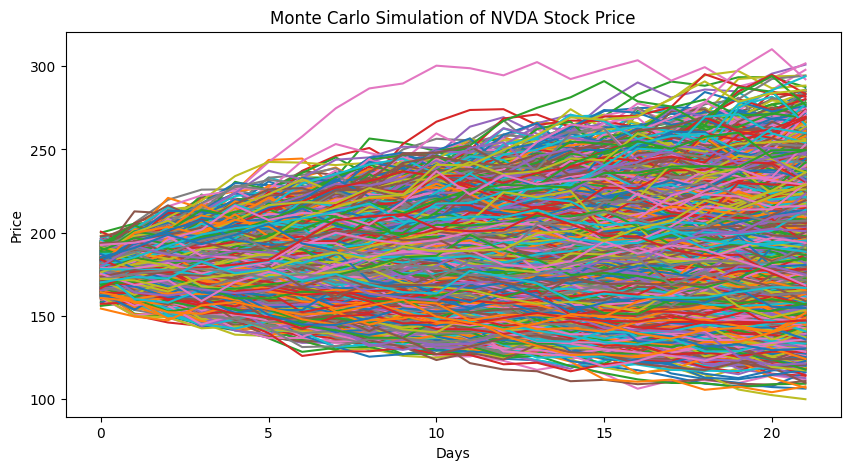

In [8]:
for simulation in range(num_simulations):
    price_list = [last_price]

    for day in range(num_days):
        price = price_list[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
        price_list.append(price)

    simulation_df[:, simulation] = price_list[1:]

final_prices = simulation_df[-1,:]

median_final_price = np.median(final_prices)

most_likely_simulation_index = np.argmin(np.abs(final_prices - median_final_price))
most_likely_simulation = simulation_df[:,most_likely_simulation_index]

plt.figure(figsize=(10,5))
plt.plot(simulation_df)
plt.title('Monte Carlo Simulation of NVDA Stock Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


In [9]:
print(f"Last price is {last_price:.2f}")
print(f"Most likely simulation's final price is {most_likely_simulation[-1]:.2f}")
print(f"Most likely simulation's return is %{(most_likely_simulation[-1]/last_price -1)*100:.2f}")

Last price is 176.99
Most likely simulation's final price is 183.86
Most likely simulation's return is %3.88


In [18]:
def get_top_drawdowns(df, column='Close'):

    prices = df[column]
    running_max = prices.iloc[0]
    peak_idx = prices.index[0]

    drawdowns = []
    current_dd_min = 0
    trough_idx = prices.index[0]
    in_drawdown = False

    for i in range(len(prices)):
        price = prices.iloc[i]
        idx = prices.index[i]

        if price >= running_max:
            if in_drawdown:
                drawdowns.append({
                    'Peak Date': peak_idx.strftime('%Y-%m-%d'),
                    'Trough Date': trough_idx.strftime('%Y-%m-%d'),
                    'Recovery Date': idx.strftime('%Y-%m-%d'),
                    'Drawdown %': round(current_dd_min * 100, 2),
                    'Days to Recover': (idx - peak_idx).days
                })
                in_drawdown = False

            running_max = price
            peak_idx = idx
            current_dd_min = 0
        else:
            in_drawdown = True
            dd = (price - running_max) / running_max
            if dd < current_dd_min:
                current_dd_min = dd
                trough_idx = idx

    # Hala toparlanamamış düşüşü ekle
    if in_drawdown:
        drawdowns.append({
            'Peak Date': peak_idx.strftime('%Y-%m-%d'),
            'Trough Date': trough_idx.strftime('%Y-%m-%d'),
            'Recovery Date': "Still Recovering",
            'Drawdown %': round(current_dd_min * 100, 2),
            'Days to Recover': None
        })

    # DataFrame'e çevir ve en büyük 3 düşüşü getir
    dd_df = pd.DataFrame(drawdowns).sort_values(by='Drawdown %').head(3)

    # İndeksleri 1, 2, 3 diye sıralayalım
    dd_df.index = range(1, len(dd_df) + 1)

    return dd_df

In [19]:
top_3 = get_top_drawdowns(df, 'Close')
print(top_3)

    Peak Date Trough Date Recovery Date  Drawdown %  Days to Recover
1  2021-11-29  2022-10-14    2023-05-25      -66.34            542.0
2  2018-10-01  2018-12-24    2020-02-14      -56.04            501.0
3  2020-02-19  2020-03-16    2020-05-11      -37.55             82.0


* Eğer timeframe günlük değişse recovery time yerine recovery bars olacak.

* Recovery time hesaplaması sonra tekrar yapılacak.